In [237]:
from skimage import segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
import cv2
import sys
import re
from struct import *
import numpy as np

In [238]:
def read_pfm(file):
    # Adopted from https://stackoverflow.com/questions/37073108/how-to-read-pfm-files-provided-with-middlebury-dataset?rq=1
    with open(file, "rb") as f:
        # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if "PF" in type:
            channels = 3
        elif "Pf" in type:
            channels = 1
        else:
            sys.exit(1)
        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = re.findall('\d+', line)
        width = int(width)
        height = int(height)

        # Line 3: +ve number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = True
        if "-" in line:
            BigEndian = False
        # Slurp all binary data
        samples = width * height * channels;
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        if BigEndian:
            fmt = ">"
        else:
            fmt = "<"
        fmt = fmt + str(samples) + "f"
        img = unpack(fmt, buffer)
        img = np.flipud(np.array(img).reshape(height, width))
    return img, height, width

In [239]:
def depthEstimation(imL, imR, numDisparities, blockSize):
    #resize the images to 3/10 of the size of the original in both x and y
    imL = cv2.resize(imL, None, fx=0.3, fy=0.3)
    imR = cv2.resize(imR, None, fx=0.3, fy=0.3)
    
    #convert the images to greyscale
    imL_gray = cv2.cvtColor(imL, cv2.COLOR_BGR2GRAY)
    imR_gray = cv2.cvtColor(imR, cv2.COLOR_BGR2GRAY)
    
    #compute the disparity map for the two images using the input bloc size and number of disparities
    stereo = cv2.StereoBM_create(numDisparities=numDisparities, blockSize=blockSize)
    disparity = stereo.compute(imL_gray, imR_gray)
    
    return disparity

In [240]:
def sumSquaredDifference(im1, im2):
    ssd = np.zeros(im1.shape,dtype=np.uint8)
    
    height, width = im1.shape
    for col in range(0, width):
        for row in range(0, height):
            ssd[row][col] = pow((im1[row][col] - im2[row][col]),2)
            
    return ssd

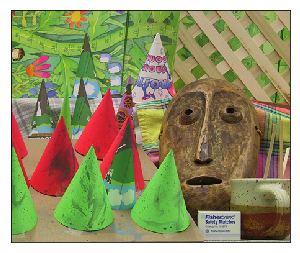

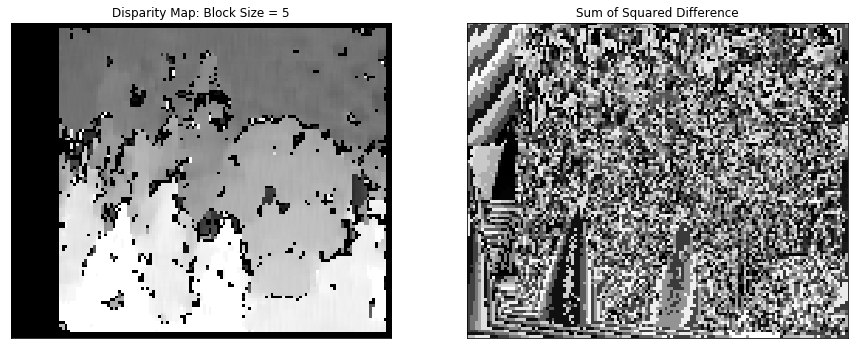

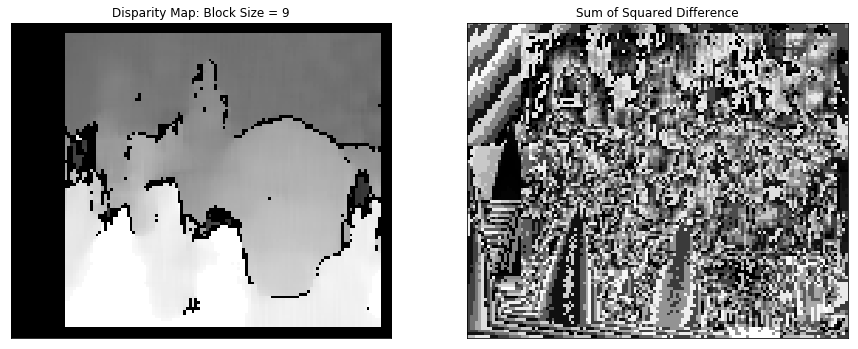

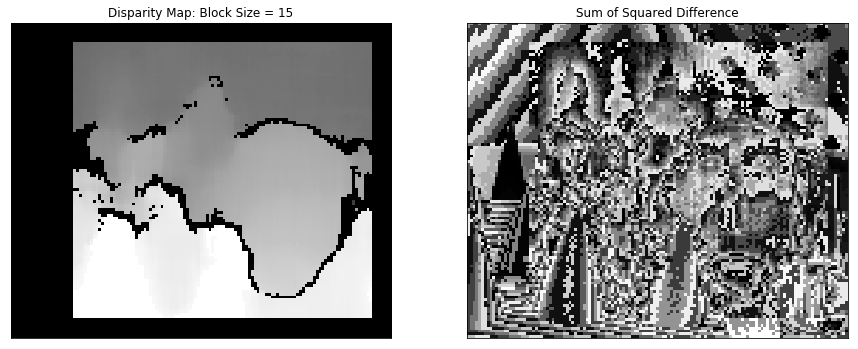

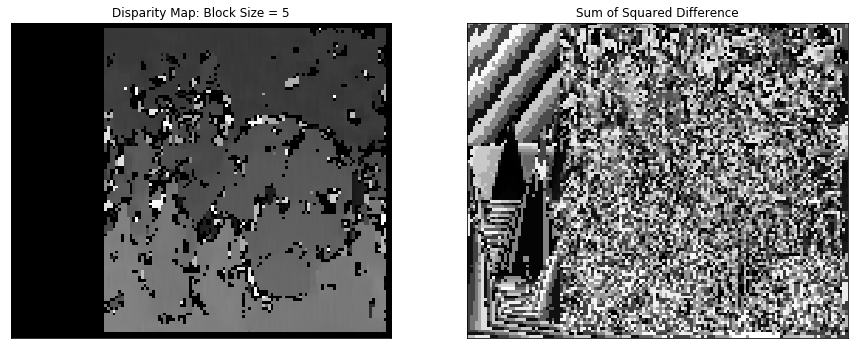

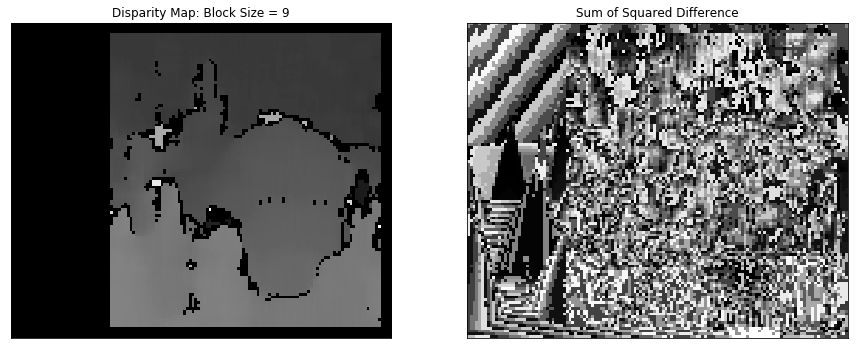

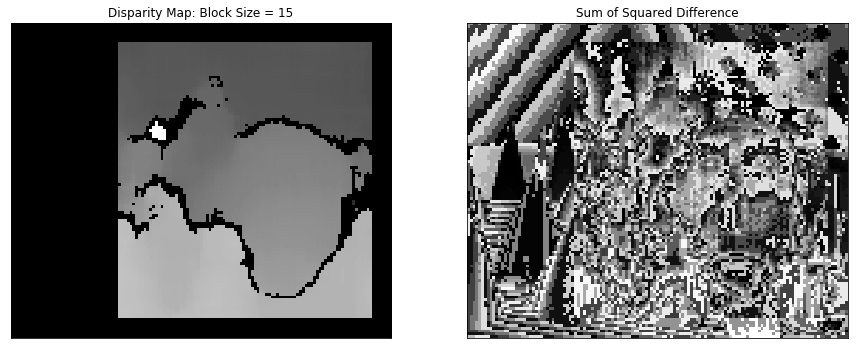

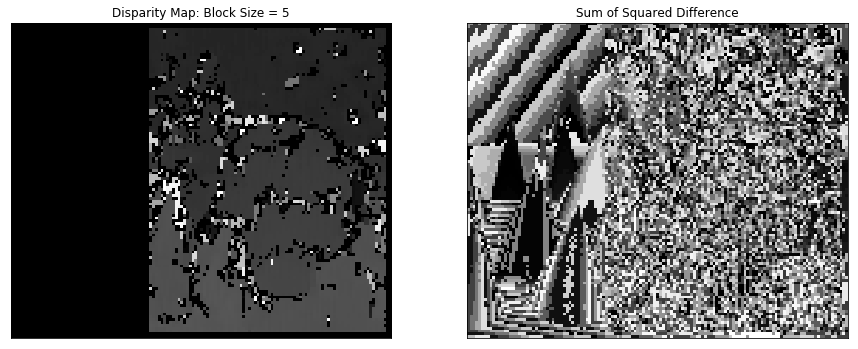

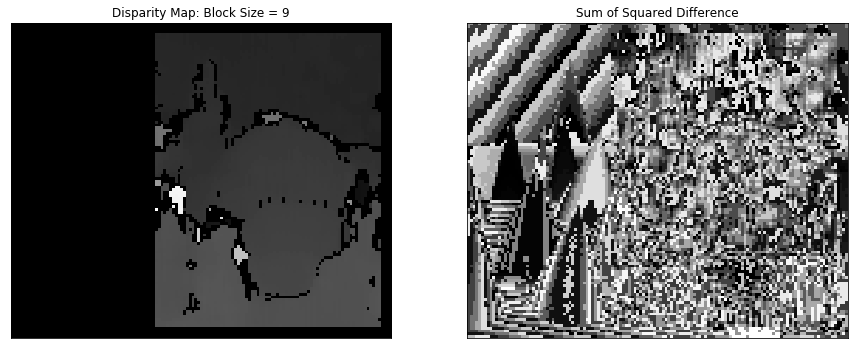

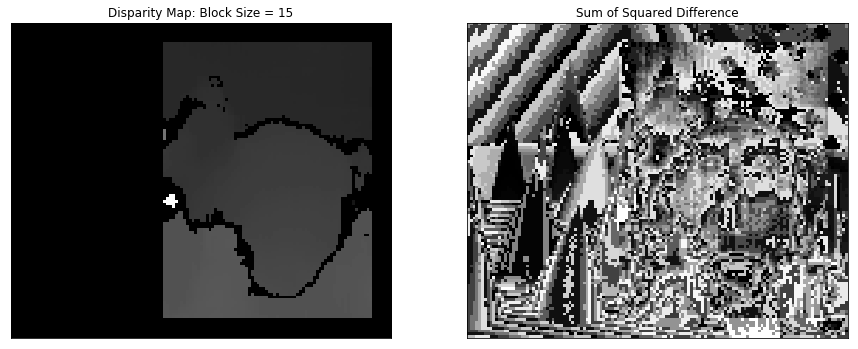

In [241]:
depth_image1= cv2.imread("im2.png")
depth_image2= cv2.imread("im6.png")

dispIm1 = cv2.imread("disp2.png")
dispIm2 = cv2.imread("disp6.png")

dispIm1 = cv2.cvtColor(dispIm1, cv2.COLOR_BGR2GRAY)
dispIm1 = cv2.resize(dispIm1, None, fx=0.3, fy=0.3)

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(depth_image1, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()


for i in range (1,4):
    disp1 = depthEstimation(depth_image1, depth_image2,i*16,5)
    ssd1 = sumSquaredDifference(dispIm1, disp1)
    
    plt.figure(figsize=(15,15))
    plt.subplot(121), plt.imshow(disp1, cmap="gray")
    plt.title("Disparity Map: Block Size = 5"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(ssd1, cmap="gray")
    plt.title("Sum of Squared Difference"), plt.xticks([]), plt.yticks([])
    plt.show()
    
    disp2 = depthEstimation(depth_image1, depth_image2,i*16,9)
    ssd2 = sumSquaredDifference(dispIm1, disp2)
    
    plt.figure(figsize=(15,15))
    plt.subplot(121), plt.imshow(disp2, cmap="gray")
    plt.title("Disparity Map: Block Size = 9"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(ssd2, cmap="gray")
    plt.title("Sum of Squared Difference"), plt.xticks([]), plt.yticks([])
    plt.show()
    
    disp3 = depthEstimation(depth_image1, depth_image2,i*16,15)
    ssd3 = sumSquaredDifference(dispIm1, disp3)
    
    plt.figure(figsize=(15,15))
    plt.subplot(121), plt.imshow(disp3, cmap="gray")
    plt.title("Disparity Map: Block Size = 15"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(ssd3, cmap="gray")
    plt.title("Sum of Squared Difference"), plt.xticks([]), plt.yticks([])
    plt.show()
    


Beginning with the first depth map (block size 5, ND = 16), it can be seen that the error is nearly random for much of the image. However, in the region of significant edges (the cones near the bottom) the error image clearly shows two of the cones that are located in the image. In addition, in the left side of the image it some more clear objects can somewhat be seen.

When we increase the block size to 9, we can begin to see some less clearly random error near the top of the image. The two cones remain as does the left side objects (which are slightly larger).

When we increase the block size again to 15, more clearly defined error can be seen in the regions that are delineated by the depth map (the points of planar change that is). Very little of the error image seems to be completely random as was the case in the first image.

Moving to BS 5, ND 32, we can see that the two cones which were very easily visible for all three of the ND 16 images are no longer visible in this image. Outised of the left side of the image where the error is clearly representative of the original image, the SSD seems to be completely random.

As we increase the block size in the next two versions from 5 -> 9 -> 15, it can be seen that, just as was the case in the ND 16 images, increasing the block size has the effect of reducing the randomness of error, especially around locations in which the depth of the image changes.

Finally, in the ND 48 images, the same thing occurs as did for the images in ND 16 and 32 which is that the increased block size is reflected in less random error and more error centralized around the changes in depth. The main difference here is that the error heavily reflects the original image in the left side of the screen for all three images.